In [2]:
import tensorflow as tf #conda
#open new env by typing 'activate newenvt' into conda
#conda install tensorflow works not pip
#redtart spyder if still doesnt work
from keras import backend as K
import os #conda
import random #conda
from tensorflow.keras.layers import Flatten
import numpy as np #pip
from tqdm import tqdm #pip
from skimage.io import imread, imshow #pip install scikit-image
from skimage.transform import resize
import matplotlib.pyplot as plt #pip matplotlib
import glob #pip install glob2
import cv2 #pip install opencv-python
from matplotlib import pyplot as plt
from PIL import Image, ImageOps

seed = 42 #random seed so the results don't change everytime we run the model
np.random.seed = seed

import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt


In [3]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# TRAIN_PATH = './Subset/training_images'
# MASK_PATH = './Subset/masks-matlab'
# TEST_PATH = './Subset/test_images'
# LOG_DIR='./logs'

TRAIN_PATH = 'D:/Training_data/training_images/TL3_random/'
MASK_PATH = 'D:/Training_data/training_mask/TL3_masks/PixelLabelData/' 
TEST_PATH = 'D:/TL3/'
LOG_DIR='logs/'

In [4]:
X_train = [] # was train_image

for directory_path in glob.glob(TRAIN_PATH):
    for TRAIN_PATH in glob.glob(os.path.join(directory_path, "*.bmp")):
        #print(TRAIN_PATH)
        img = Image.open(TRAIN_PATH)
        img = img.resize((SIZE_X, SIZE_Y), Image.ANTIALIAS) #resize the image
        img = np.array(img)

        #img = cv2.imread(TRAIN_PATH, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        X_train.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing
X_train = np.array(X_train)

In [5]:
X_train.shape

(387, 256, 256, 3)

In [6]:
#Capture mask/label info as a list
Y_train = [] #was train_mask
for directory_path in glob.glob(MASK_PATH):
    l=glob.glob(os.path.join(directory_path, "*"))
    l.sort(key=lambda x:int(x.split(os.sep)[-1].split("_")[1].split(".")[0]))
    for MASK_PATH in l:
        mask = cv2.imread(MASK_PATH, 0)
        n=mask==1
        mask[n]= 1
        mask[~n]= 0
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        Y_train.append(mask)
        #train_labels.append(label)
        #mask = np.maximum(mask, mask_) #PICKS LARGEST VALUE?
#Convert list to array for machine learning processing
Y_train = np.array(Y_train)

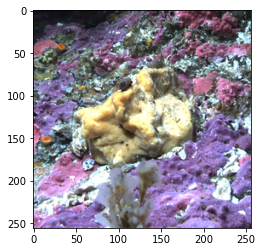

In [7]:
plt.imshow(X_train[44])

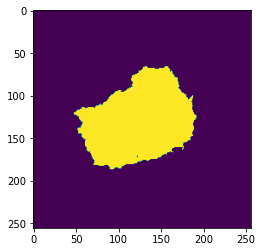

In [8]:
plt.imshow(Y_train[44])

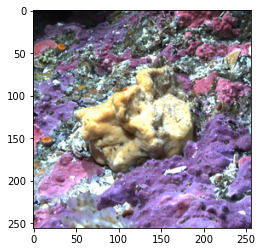

In [9]:
plt.imshow(X_train[20])

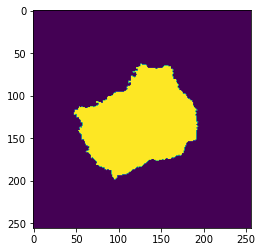

In [10]:
plt.imshow(Y_train[20])

In [11]:
X_test = [] #was for testing images
for directory_path in glob.glob(TEST_PATH):
    for TEST_PATH in glob.glob(os.path.join(directory_path, "*.bmp")):
        img = Image.open(TEST_PATH)
        img = img.resize((SIZE_X, SIZE_Y), Image.ANTIALIAS) #resize the image
        img = np.array(img)

        #test = cv2.imread(TEST_PATH, 0)
        #test = cv2.resize(test, (SIZE_Y, SIZE_X))
        #test = cv2.cvtColor(test, cv2.COLOR_RGB2BGR)
        X_test.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing
X_test = np.array(X_test)

In [12]:
X = X_train # was train_images
Y = Y_train #was train_mask
Y_train = Y_train.astype(np.float32)

In [13]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)


In [14]:
def dice_coef(y_true, y_pred):
    smooth = 1e-4
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    """
    Helper function to calculate dice loss
    """
    return 1-dice_coef(y_true, y_pred)



In [15]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
adam=tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=adam, loss = dice_coef_loss, metrics=[dice_coef, 'accuracy'])
#model.compile(optimizer=adam, loss = "binary_crossentropy", metrics=[dice_coef, 'accuracy'])
#model.summary()

In [16]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Belinda.ckpt', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    #tf.profiler.experimental.stop(logdir = r'E:\Dominica-test\images\logs'),
    tf.keras.callbacks.TensorBoard(log_dir = LOG_DIR), #saves to file where python code is
   checkpointer
]


In [17]:
model.fit(X_train, Y_train,validation_split=0.2, batch_size=16, epochs=50 )

Epoch 1/50
20/20 [==============================] - 95s 5s/step - loss: 0.7737 - dice_coef: 0.2267 - accuracy: 0.7947 - val_loss: 0.7406 - val_dice_coef: 0.2598 - val_accuracy: 0.7297
Epoch 2/50
20/20 [==============================] - 93s 5s/step - loss: 0.7406 - dice_coef: 0.2595 - accuracy: 0.6101 - val_loss: 0.7131 - val_dice_coef: 0.2873 - val_accuracy: 0.2597
Epoch 3/50
20/20 [==============================] - 93s 5s/step - loss: 0.7152 - dice_coef: 0.2854 - accuracy: 0.3514 - val_loss: 0.6840 - val_dice_coef: 0.3164 - val_accuracy: 0.1952
Epoch 4/50
20/20 [==============================] - 94s 5s/step - loss: 0.6512 - dice_coef: 0.3521 - accuracy: 0.4160 - val_loss: 0.6044 - val_dice_coef: 0.3964 - val_accuracy: 0.4796
Epoch 5/50
20/20 [==============================] - 96s 5s/step - loss: 0.3653 - dice_coef: 0.6417 - accuracy: 0.9191 - val_loss: 0.5563 - val_dice_coef: 0.4446 - val_accuracy: 0.5652
Epoch 6/50
20/20 [==============================] - 94s 5s/step - loss: 0.1432 -

20/20 [==============================] - 94s 5s/step - loss: 0.0664 - dice_coef: 0.9338 - accuracy: 0.9773 - val_loss: 0.4367 - val_dice_coef: 0.5642 - val_accuracy: 0.7219
Epoch 46/50
20/20 [==============================] - 94s 5s/step - loss: 0.0665 - dice_coef: 0.9341 - accuracy: 0.9772 - val_loss: 0.4274 - val_dice_coef: 0.5736 - val_accuracy: 0.7327
Epoch 47/50
20/20 [==============================] - 93s 5s/step - loss: 0.0659 - dice_coef: 0.9345 - accuracy: 0.9775 - val_loss: 0.4219 - val_dice_coef: 0.5790 - val_accuracy: 0.7386
Epoch 48/50
20/20 [==============================] - 94s 5s/step - loss: 0.0653 - dice_coef: 0.9344 - accuracy: 0.9777 - val_loss: 0.4081 - val_dice_coef: 0.5928 - val_accuracy: 0.7531
Epoch 49/50
20/20 [==============================] - 94s 5s/step - loss: 0.0652 - dice_coef: 0.9350 - accuracy: 0.9777 - val_loss: 0.4334 - val_dice_coef: 0.5675 - val_accuracy: 0.7259
Epoch 50/50
20/20 [==============================] - 94s 5s/step - loss: 0.0658 - dice_

In [18]:

preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)



preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
np.save("test_set_dice_inverted_masks-TL3.npy", preds_test_t) #save this data set into a numpy not sure where check later

31/31 [==============================] - 52s 2s/step


In [19]:
dataset ="timeseries_3" #change it for different timeseries
model_name = "Belinda_" + dataset + ".h5"
model.save(model_name)

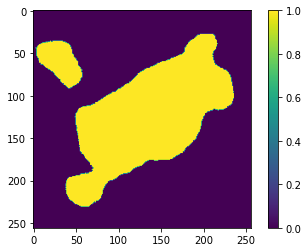

In [20]:
plt.imshow(np.squeeze(preds_test_t[10]))
plt.colorbar()

In [21]:
preds_test_t[10]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

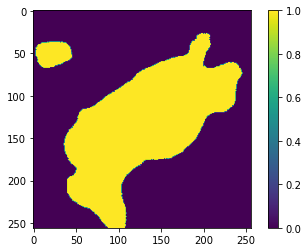

In [22]:
plt.imshow(np.squeeze(preds_train_t[35]))
plt.colorbar()

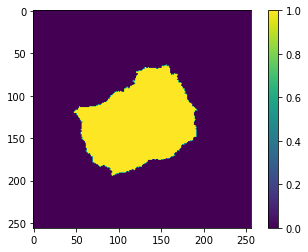

In [23]:
plt.imshow(np.squeeze(Y_train[10]))
plt.colorbar()

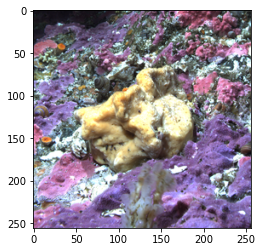

In [24]:
plt.imshow(np.squeeze(X_train[10]))


In [25]:
pred = model.predict(np.expand_dims(X_train[10],0), verbose=1)

1/1 [==============================] - 0s 138ms/step


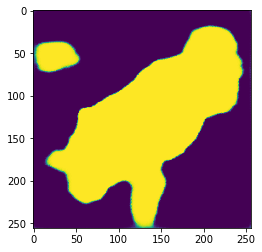

In [26]:
plt.imshow(np.squeeze(pred))